# Example: Spectral Analysis - Part 2/2

- Author: Dr. Daning Huang
- Date: 09/07/2025
- Updated: 12/08/2025

## Introduction

The spectral analysis here concerns with the spectrum of a linear operator, or more specifically the Koopman operator of a dynamical system $\dot{x}=f(x)$.  Using the continuous-time version, i.e., the Koopman generator $L=f\cdot\nabla$, one can define an eigenvalue problem, similar to the linear algebra case

$$
L\varphi = \lambda\varphi
$$

where $\lambda$ and $\varphi(x)$ are the eigenvalue and *eigenfunction*, respectively.  For an infinite-dimensional operator like $L$, there are infinitely many eigenpairs, and in fact there are more subtle forms of eigenpairs involving continuous and residual spectra.

Practically, the eigenvalues reveal the stability of the dynamics, just like its linear system counterpart, but such characterization of stability extends to the entire attraction basin of the dynamics (i.e., not near a fixed point or limit cycle).  The eigenfunctions give more information about the state space, such as isochrons and isostables, that characterize the underlying dynamics - which we will see below.

For more details on Koopman, one can refer to the vast body of literature in this field.  One good reference is perhaps [this one](https://link.springer.com/book/10.1007/978-3-030-35713-9).

**For the current example**, the dynamics exhibits a globally stable limit cycle.  The Koopman operator/generator has only the point spectrum, which consists of three parts:

- Periodic part: On the limit cycle, the response is periodic.  Suppose the base frequency is $\omega_0$, then $\pm n\omega_0 i$, $n=1,2,\cdots$ are all Koopman eigenvalues.  Intuitively, this is the Fourier expansion of the limit cycle.
- Pure decay: When the states are sufficiently close to the LC, their distance to the LC exponentially decays.  This corresponds to a negative real eigenvalue, which effectively gives the Floquet exponent.
- Composition of the above: If $(\lambda_1,\varphi_1)$ and $(\lambda_2,\varphi_2)$ are Koopman eigenpairs, then $(\lambda_1+\lambda_2,\varphi_1\varphi_2)$ is also an eigenpair.  This property forms a lattice of eigenvalues composing the above two types of eigenpairs.
- Technically, the conjugate eigenpair of base frequency plus the first pure decay eigenpair are sufficient to reconstruct the dynamics surrounding the LC in a linear form.

In the results below, we will see how the `SpectralAnalysis` module in DyMAD reveals the above spectral properties.

## Preparation

As usual, a bunch of imports - note the new `SpectralAnalysis` class.

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as spi
import torch

from dymad.models import DKBF, KBF
from dymad.numerics import complex_plot
from dymad.sako import per_state_err, SpectralAnalysis
from dymad.utils import TrajectorySampler

Some lines of code from Part I for dynamics and sampling.

In [2]:
N = 81
t_grid = np.linspace(0, 8, N)
dt = t_grid[1] - t_grid[0]

mu = 1.0
def f(t, x):
    _x, _y = x
    dx = np.array([
        _y,
        mu * (1-_x**2)*_y - _x
    ])
    return dx
g = lambda t, x: x

_Nt = 161
_ts = np.linspace(0, 40.0, 8*_Nt)
_res = spi.solve_ivp(f, [0,_ts[-1]], [2,2], t_eval=_ts)
_ref = _res.y[:,-240:].T

db = 0.4
smpl = {'x0': {
    'kind': 'perturb',
    'params': {'bounds': [-db, db], 'ref': _ref}}
    }

The reference frequencies of LC as ground truth.

In [3]:
# Reference frequencies
_tmp = _res.y[0,-4*_Nt:]
_dt = _ts[1]           # dt from reference
sp = np.fft.fft(_tmp)
fr = np.fft.fftfreq(4*_Nt)/_dt*(2*np.pi)
ii = np.argmax(np.abs(sp))
w0 = np.abs(fr[ii])
wc = np.array([-5,-4,-3,-2,-1,1,2,3,4,5]) * (1j*w0)  # Only the first 5 pairs
wa = np.exp(wc*dt)     # Use dt from data

Load the models trained in Part I to produce the `SpectralAnalysis` objects.

In [4]:
saln = SpectralAnalysis(DKBF, 'sa_dkbf_ln.pt', dt=dt, reps=1e-10, etol=None)  # Full DMD
satr = SpectralAnalysis(DKBF, 'sa_dkbf_tr.pt', dt=dt, reps=1e-10, etol=None)  # Truncated DMD
sasa = SpectralAnalysis(DKBF, 'sa_dkbf_sa.pt', dt=dt, reps=1e-10, etol=None)  # ResDMD
sadt = SpectralAnalysis(DKBF, 'sa_dkbf_nd.pt', dt=dt, reps=1e-10)   # Discrete-time autoencoder model
sact = SpectralAnalysis(KBF,  'sa_kbf_nd.pt',  dt=dt, reps=1e-10)   # Continuous-time version

sas = [saln, satr, sasa, sadt, sact]
lbs = ['DT-LN', 'DT-TR', 'DT-SA', 'DT-ND', 'CT-ND']

Ns  = len(sas)

## Comparison - Prediction

Let's first look at the predictive accuracy of the models.  In `SpectralAnalysis`, we provide a handy function to predict and plot the dynamics, with comparison to truth.  Clearly, the truncated DMD does not perform well.

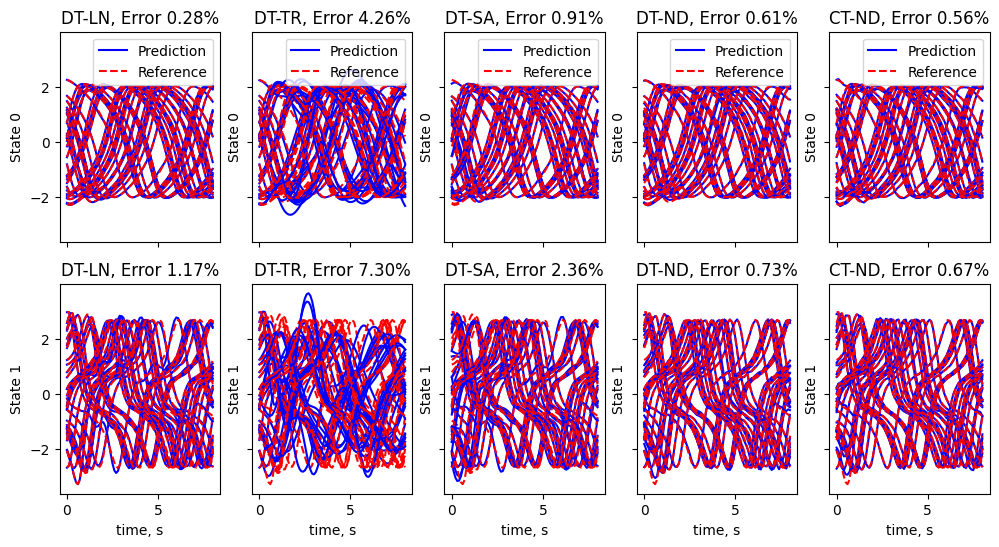

In [5]:
J = 32
sampler = TrajectorySampler(f, g, config='sa_data.yaml', config_mod=smpl)
ts, xs, _ = sampler.sample(t_grid, batch=J)
x0s = xs[:, 0, :].squeeze()

fig, ax = plt.subplots(nrows=2, ncols=Ns, sharex=True, sharey=True, figsize=(12,6))
for _i in range(Ns):
    sas[_i].plot_pred(x0s, ts[0], ref=xs, title=lbs[_i], fig=(fig, ax[:,_i]))

The reason is the following.  DMD effectively solves the following problem

$$
\min_A \|X^1-XA\|
$$

where $X$ is the row-wise collection of the current steps, and $X^1$ is the next steps.

The full DMD solves $A=X^+X^1$, where $X^+$ is the pseudo-inverse, typically computed by SVD.  All the eigenpairs of $A$ are retained in prediction.

The truncated DMD solves $A\approx \hat{X}^+X^1$, where $\hat{X}^+$ is a low-rank approximation of the pseudo-inverse, typically computed by truncated SVD.  The full and truncated DMD's usually produce very similar leading eigenpairs; this might be sufficient for modal analysis purposes.  However, the two matrices would start to differ at larger eigenvalues, which eventually leads to errors in prediction.

As for ResDMD, it takes an alternative approach, that first solves for all possible eigenpairs, and then uses the data to select the better eigenpairs with lower residual.  Here residual effectively estimates $\|Ku-\lambda u\|$ for eigenpair $(\lambda, u)$, where $K=\exp(L\Delta t)$.  As a result, ResDMD uses fewer modes like truncated DMD, but the modes are more accurate and lead to better predictions.

**Convergence:**

The residual criteria in ResDMD is general and can be applied to full DMD as well.  To understand the models more, we can truncate full DMD for a series of orders by residual, and compare the prediction error.

As expected, the truncation order decreases, the error increases.  Full and truncated DMD perform similarly at order 15, but ResDMD is far better at the same order.  This is because ResDMD uses a generalized eigenvalue problem formulation to find all the eigenpairs, as opposed to the least-squares + standard EVP in the other two.

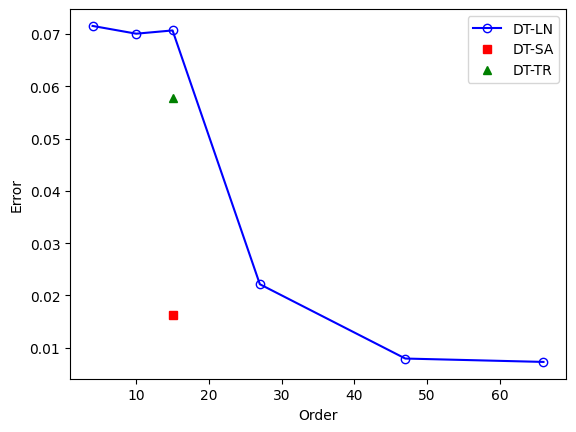

In [6]:
errs = []
for _o in [3, 9, 15, 27, 47, 65]:
    saln.filter_spectrum(order=_o, remove_one=False)
    prd = saln.predict(x0s, ts[0])
    err = per_state_err(prd.real, xs)
    errs.append([saln._Nrank, np.mean(err)])
errs = np.array(errs).T

prd = sasa.predict(x0s, ts[0])
esa = per_state_err(prd.real, xs)

prd = satr.predict(x0s, ts[0])
etr = per_state_err(prd.real, xs)

fig = plt.figure()
plt.plot(errs[0], errs[1], 'bo-', label='DT-LN', markerfacecolor='none')
plt.plot(sasa._Nrank, np.mean(esa), 'rs', label='DT-SA')
plt.plot(satr._Nrank, np.mean(etr), 'g^', label='DT-TR')
plt.legend()
plt.xlabel('Order')
plt.ylabel('Error');

## Comparison - Spectra and Pseudospectra

Next, we compare all the five models by their spectral properties.

The discrete-time version of spectra are plotted below.  The crosses mark the first 5 conjugate pairs of eigenvalues of the limit cycle; as expected, they all lie on the unit circle representing harmonic oscillations.

The circles are the eigenvalues obtained by the learned models.  Full DMD captures the LC eigenvalues well, and has also many eigenvalues inside the unit circle representing decaying modes - although not all of them are accurate.

The truncated DMD only gets the first 1-2 pairs of LC eigenvalues right, and the rest show spurious decay; this contributed to inaccurate predictions.

The ResDMD shows a clean set of eigenvalues: those on the unit circle align well with the truth, and the rest capture the first few decaying modes.

As for the autoencoder-based models, they only produce a conjugate pair of eigenvalues for fundamental frequencies and one negative real eigenvalue for the pure decay.  This is because these two models take the "inductive bias" route, that forces the autoencoder to find the correct coordinate transform to convert the LCO problem into the 3 base modes.

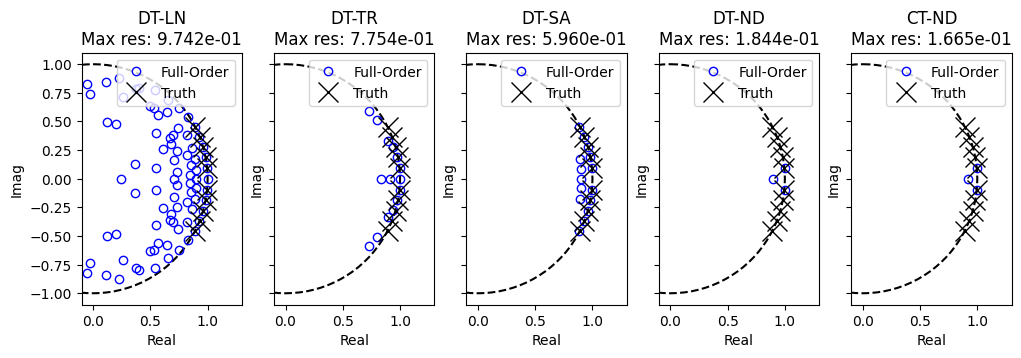

In [7]:
MRK = 15
fig, ax = plt.subplots(ncols=Ns, sharey=True, figsize=(12,5))
for _i in range(Ns):
    fig, ax[_i], _ls = sas[_i].plot_eigs(fig=(fig, ax[_i]), plot_filt=None)
    _l, = ax[_i].plot(wa.real, wa.imag, 'kx', markersize=MRK)
    ax[_i].set_title(f'{lbs[_i]}\nMax res: {sas[_i]._res[-1]:4.3e}')
    ax[_i].legend(_ls+[_l], ["Full-Order", "Truth"], loc=1)

for _i in range(Ns):
    ax[_i].set_xlim([-0.1, 1.3])
    ax[_i].set_ylim([-1.1, 1.1])

In addition, we can also compute the pseudospectra of the learned models.

The pseudospectrum of an operator is a set containing the spectrum of the operator and the numbers that are "almost" eigenvalues.  Formally, this is 

$$
\Lambda_\epsilon(L)=\{s\in\mathbb{C}|\|(L-s I)^{-1}\|\geq 1/\epsilon\}
$$

The pseudospectrum can be a way to detect continuous spectrum as well as non-normality of a system.  Once one obtains a finite-dimensional approximation of a Koopman operator, i.e., a matrix, one can compute the pseudospectrum by computing that of the matrix.  Alternatively, one can also estimate the operator pseudospectrum directly from data, using e.g. an algorithm that accompanies ResDMD.  DyMAD provides both implementations.

In the plots below, dotted contours are from the first approach, so it always surrounds the eigenvalues, while the solid contours are computed from data and may indicate a different pseudospectrum.  As a rule of thumb, in a good model, both pseudospectra should enclose the eigenvalues (like in ResDMD and autoencoder models), otherwise there are either excessive eigenvalues (full DMD) or incorrect/incomplete eigenvalues (truncated DMD).

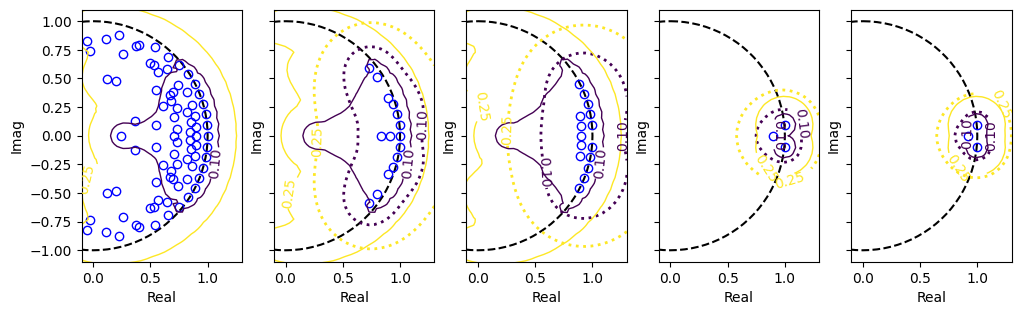

In [8]:
MRK = 15
fig, ax = plt.subplots(ncols=Ns, sharey=True, figsize=(12,5))
for _i in range(Ns):
    fig, ax[_i], _ls = sas[_i].plot_eigs(fig=(fig, ax[_i]), plot_filt=None)

# Pseudospectra
xs = np.linspace(-1.3, 1.3, 51)
gg = np.vstack([xs, xs])
rng = np.array([0.1, 0.25])

# Predicted
pss, psk = [], []
for _s in sas:
    grid, _pss = _s.estimate_ps(gg, mode='disc', method='standard', return_vec=False)
    grid, _psk = _s.estimate_ps(gg, mode='disc', method='sako', return_vec=False)
    pss.append((grid, _pss))
    psk.append((grid, _psk))

for _i in range(Ns):
    grid, _pss = pss[_i]
    grid, _psk = psk[_i]
    f, ax[_i] = complex_plot(grid, 1/_pss, rng, fig=(f, ax[_i]), mode='line', lwid=2, lsty='dotted')
    f, ax[_i] = complex_plot(grid, 1/_psk, rng, fig=(f, ax[_i]), mode='line', lwid=1)

for _i in range(Ns):
    ax[_i].set_xlim([-0.1, 1.3])
    ax[_i].set_ylim([-1.1, 1.1])

Below the continuous-time version of spectra and pseudospectra are plotted.  The same discussion applies.

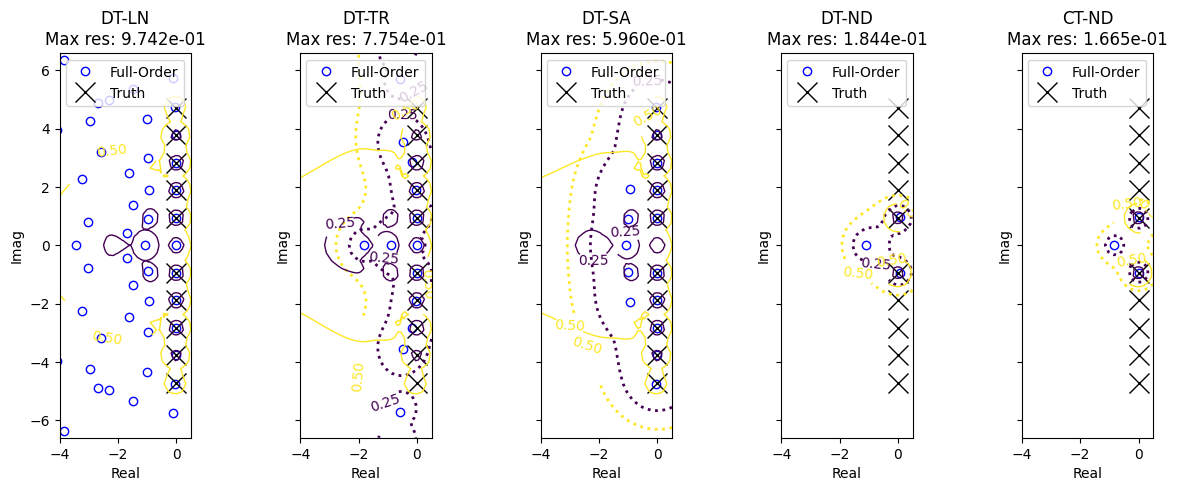

In [9]:
MRK = 15
fig, ax = plt.subplots(ncols=Ns, sharey=True, figsize=(15,5))
for _i in range(Ns):
    fig, ax[_i], _ls = sas[_i].plot_eigs(fig=(fig, ax[_i]), mode='cont', plot_filt=None)
    _l, = ax[_i].plot(wc.real, wc.imag, 'kx', markersize=MRK)
    ax[_i].set_title(f'{lbs[_i]}\nMax res: {sas[_i]._res[-1]:4.3e}')
    ax[_i].legend(_ls+[_l], ["Full-Order", "Truth"], loc=1)

# Pseudospectra
zs = np.linspace(-4.0,0.5,51)
ws = np.linspace(-6.6,6.6,51)
gg = np.vstack([zs,ws])
rng = np.array([0.25, 0.5])
# Predicted
pss, psk = [], []
for _s in sas:
    grid, _pss = _s.estimate_ps(gg, mode='cont', method='standard', return_vec=False)
    grid, _psk = _s.estimate_ps(gg, mode='cont', method='sako', return_vec=False)
    pss.append((grid, _pss))
    psk.append((grid, _psk))

for _i in range(Ns):
    grid, _pss = pss[_i]
    grid, _psk = psk[_i]
    fig, ax[_i] = complex_plot(grid, 1/_pss, rng, fig=(fig, ax[_i]), mode='line', lwid=2, lsty='dotted')
    fig, ax[_i] = complex_plot(grid, 1/_psk, rng, fig=(fig, ax[_i]), mode='line', lwid=1)

for _i in range(2):
    ax[_i].set_xlim([-4.0, 0.5])
    ax[_i].set_ylim([-6.6, 6.6])

An additional functionality in DyMAD is the estimation of spectral measure of an arbitrary observation of the states.  Conceptually one can think this as the FFT of the observation along the periodic response, i.e., the limit cycle, or the "cross-section" of pseudospectra along the unit circle.

Below we pick the observation $g(x)=s^3+\dot{s}^3$.  The DMD models show multiple peaks at the harmonics due to the many eigenvalues, while the other two models show only two peaks as they are designed to "squeeze" all harmonics to the base frequencies.

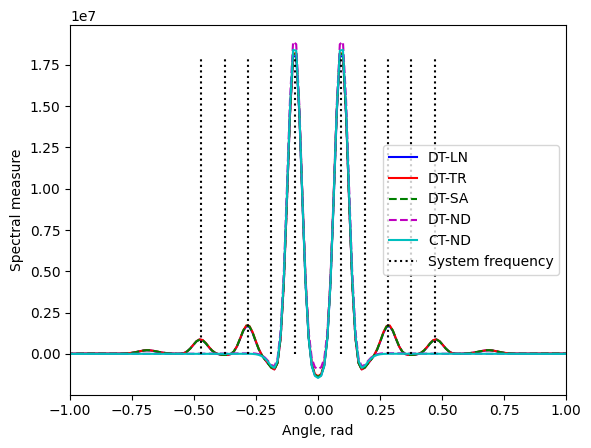

In [10]:
stys = ['b-', 'r-', 'g--', 'm--', 'c-']
def func_obs(x):
    _x1, _x2 = x.T
    return _x1**3+_x2**3
vgs = []
for _s in sas:
    _t, _v = _s.estimate_measure(func_obs, 6, 0.1, thetas=501)
    vgs.append((_t, _v))

_arg = np.angle(wa)
_amp = np.max(vgs[0][1])

f = plt.figure()
for _i in range(Ns):
    th, vg = vgs[_i]
    plt.plot(th, vg, stys[_i], label=lbs[_i], markerfacecolor='none')
plt.plot([_arg[0], _arg[0]], [0, _amp], 'k:', label='System frequency')
for _a in _arg[1:]:
    plt.plot([_a, _a], [0, _amp], 'k:')
plt.legend()
plt.xlabel('Angle, rad')
plt.ylabel('Spectral measure')
plt.xlim([-1,1]);

## Comparison - Eigenfunctions

Lastly we plot the eigenfunctions of the learned models.  Specifically, we pick those corresponding to the first two frequencies, except the last two, that have only one.  The left two columns show $|\varphi|$ (isostables) and the right two show $\mathrm{Arg}(\varphi)$ (isochrons).  The black dashed lines show the limit cycle.

Conceptually, points on the same contour of isostable approach the LC at the same rate, while points on the same contour of isochron share the same phase and converge to the same point on LC.  In the isochron plots, higher harmonics show more periods along the limit cycle.

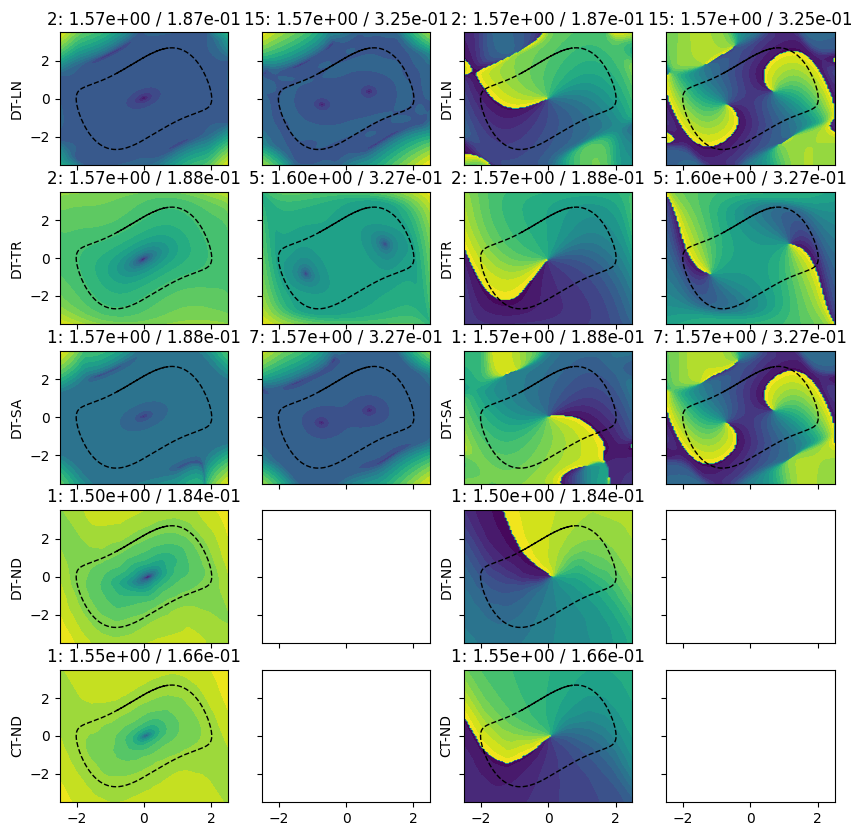

In [11]:
rngs = [[-2.5, 2.5], [-3.5, 3.5]]
Ne = [101, 121]

fig, ax = plt.subplots(nrows=Ns, ncols=4, sharex=True, sharey=True, figsize=(10, 10))
a1, a2 = ax[:,:2], ax[:,2:]
for i in range(Ns):
    _i1 = np.argmin(np.abs(sas[i]._wc - w0*1j))
    _i2 = np.argmin(np.abs(sas[i]._wc - 2*w0*1j))
    _idx = list(set([_i1, _i2]))
    sas[i].plot_eigfun_2d(rngs, Ne, _idx, mode='log', fig=(fig, a1[i]))
    a1[i][0].set_ylabel(lbs[i])
    sas[i].plot_eigfun_2d(rngs, Ne, _idx, mode='angle', fig=(fig, a2[i]))
    a2[i][0].set_ylabel(lbs[i])

    for _i in range(len(_idx)):
        a1[i][_i].plot(_ref[:,0], _ref[:,1], 'k--', linewidth=1)
        a2[i][_i].plot(_ref[:,0], _ref[:,1], 'k--', linewidth=1)